## Essential Libraries 

In [1]:
# utilities
import datetime
import json
import os, sys
import re
import numpy as np
import pandas as pd
import time


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Natural Language Toolkit (nltk)
from nltk.stem import WordNetLemmatizer
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords



#Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import decomposition

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Import

In [2]:
links = ['/kaggle/input/politics/', '/kaggle/input/entertainment/', '/kaggle/input/business/', '/kaggle/input/bbc-sport/', '/kaggle/input/technology/']
links

['/kaggle/input/politics/',
 '/kaggle/input/entertainment/',
 '/kaggle/input/business/',
 '/kaggle/input/bbc-sport/',
 '/kaggle/input/technology/']

In [3]:
def read_category(category):
    for dirname, _, filenames in os.walk('/kaggle/input'+'/'+category):
        filenames.sort()
        business_files = []
        for filename in filenames:
            business_files.append(os.path.join(dirname, filename))
    
    
    ent_files = [file for file in business_files if file.endswith(".txt")]
    raw_documents = []
    snippets = []
    for index in range(0, len(ent_files)):
        with open(ent_files[index], "r") as fin: #must have exactly one of create/read/write/append mode
            for line in fin.readlines():
                text = line.strip()
                raw_documents.append(text)
                snippets.append(text[0:min(len(text),10)])
    print("Read %d raw text documents" % len(raw_documents))
    return raw_documents
    

## Business

In [4]:
Business = read_category('business')

Read 4860 raw text documents


## Preprocess Text
Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

- Lower Casing: Each text is converted to lowercase. #Helps to keep things normalized
- Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
- Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
- Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
- Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
- Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- Removing Short Words: Words with length less than 2 are removed.
- Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
- Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [5]:

mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [6]:
stopwordlist = stopwords.words('english') + mystopwordlist
stopwordlist = set(stopwordlist)
stopwordlist = list(stopwordlist)

In [7]:

def preprocess(document):
    processedText = []
    
    #creating a Lemmatizer
    wordLemma = WordNetLemmatizer() #define the imported library
    
    # Defining regular expression pattern we can find. in wordss
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # e.g check out https://dot.com for more
    #userPattern       = '@[^\s]+' # e.g @FagbamigbeK check this out
    alphaPattern      = "[^a-zA-Z0-9]" # e.g I am *10 better!
    sequencePattern   = r"(.)\1\1+"  # e.g Heyyyyyyy, I am back!
    seqReplacePattern = r"\1" # e.g Replace Heyyyyyyy with Heyy
    
    
    for words in document:
        words = words.lower() #normalizing all text to a lower case
        
        
        # Replace all URls with 'URL'
        words = re.sub(urlPattern,' URL',words) #using the substitution method of the regular expression library
        
        
        # Replace all non alphabets.
        words = re.sub(alphaPattern, " ", words) # e.g I am *10 better!
        
        
        # Replace 3 or more consecutive letters by 2 letter.
        words = re.sub(sequencePattern, seqReplacePattern, words) # e.g Replace Heyyyyyyy with Heyy
        
        
        wordswords = ''
        for word in words.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                wordswords += (word + ' ')
        
        processedText.append(wordswords)
        
    return processedText

## Noting the time text preprocessing took

In [8]:
t = time.time()
business_data = preprocess(Business) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} second(s)')

Text Processing Done.
Time taken for text processing: 3 second(s)


## Word Cloud

In [9]:
word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False)

In [10]:
Business_processed_text = []
for words in business_data:
    words = words.lower().replace("ha","")
    words = words.lower().replace("wa","")
    words = words.lower().replace("said","")
    words = words.lower().replace("ve","")
    words = words.lower().replace("tt","")
    words = words.lower().replace("will","")
    Business_processed_text.append(words)

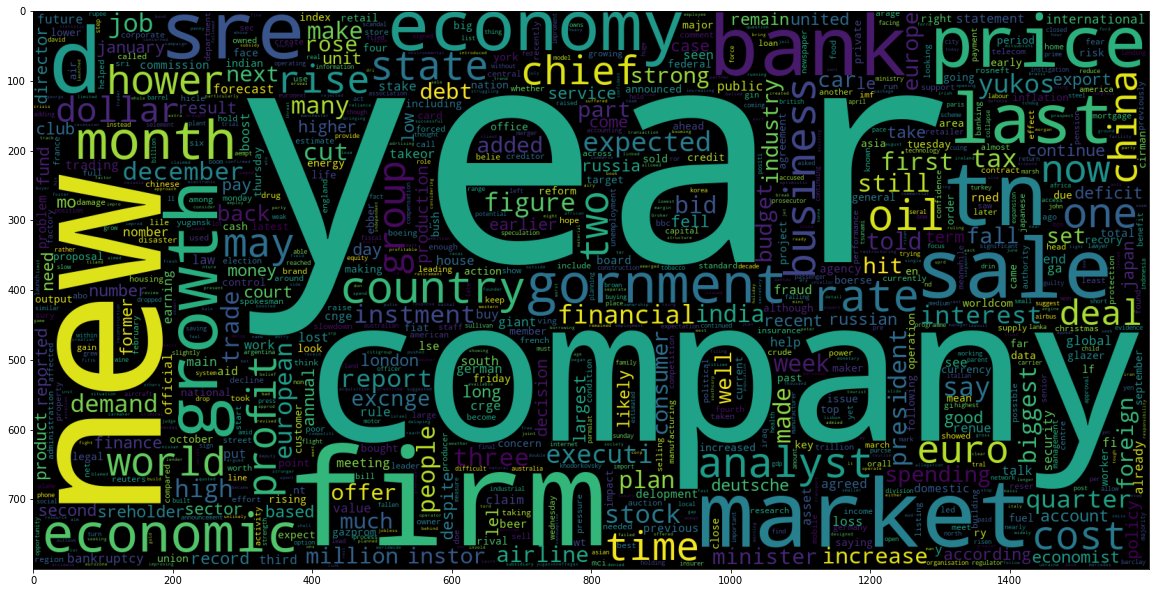

In [11]:
plt.figure(figsize = (20,20))
Business_wc = word_cloud.generate(" ".join(Business_processed_text))
plt.imshow(Business_wc)

## Count Vectorizer

In the bag-of-words model, each document is represented by a vector in a m-dimensional coordinate space, where m is number of unique terms across all documents. This set of terms is called the corpus vocabulary.

Since each document can be represented as a term vector, we can stack these vectors to create a full document-term matrix. We can easily create this matrix from a list of document strings using CountVectorizer from Scikit-learn. The parameters passed to CountVectorizer control the pre-processing steps that it performs.

In [12]:
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stopwordlist, min_df = 20)
A = vectorizer.fit_transform(Business_processed_text)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 4860 X 906 document-term matrix


## Applying Term Weighting with TF-IDF
We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. The most common normalisation is term frequency–inverse document frequency (TF-IDF). In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using TfidfVectorizer in place of CountVectorizer.

- stop_words = custom list containing words to filter
- min_df = 20 filter terms that appears in less than 20 documents
- max_df = 1000 filter terms that appear in greater than 1000 documents
- ngram_range = 2 includes phrase of two words instead of just single words

In [13]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words = stopwordlist, min_df = 20, max_df = 800)
A = vectorizer.fit_transform(Business_processed_text)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )


terms =  list(vectorizer.get_feature_names())

Created 4860 X 906 TF-IDF-normalized document-term matrix


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


A simple characterisation that we might do would be to look at the terms with the highest TF-IDF scores across all documents in the document-term matrix. We can define such a function as follows:

In [14]:
def rank_terms( A, terms):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=lambda item: item[1], reverse = True)

In [15]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. year (92.29)
02. firm (75.62)
03. company (70.78)
04. market (63.23)
05. sre (60.65)
06. bank (59.90)
07. sale (57.72)
08. economy (54.63)
09. tn (54.06)
10. growth (52.41)
11. new (52.10)
12. price (50.77)
13. profit (50.24)
14. would (49.64)
15. oil (45.51)
16. also (44.58)
17. gornment (43.88)
18. rate (43.63)
19. last (42.39)
20. economic (41.92)


## Using Non-Negative Matrix Factorization

In [16]:
from sklearn import decomposition
k = 10
model = decomposition.NMF(n_components = k, init = "nndsvd")
W = model.fit_transform(A)
H = model.components_

NMF produces to factor matrices as its output: W and H.

The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.



The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [17]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms



descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: growth, economy, year, rate, economic, month, consumer, figure, quarter, spending
Topic 02: firm, company, would, country, deal, gornment, new, business, also, india
Topic 03: yukos, russian, court, oil, tax, gazprom, bankruptcy, unit, yugansk, auction
Topic 04: profit, sale, year, car, euro, rise, tn, retail, december, christmas
Topic 05: bank, rate, china, interest, hold, central, england, south, banking, loan
Topic 06: price, oil, high, crude, house, market, barrel, abo, fall, demand
Topic 07: dollar, euro, deficit, budget, low, hit, record, trade, currency, bush
Topic 08: sre, hit, news, company, drug, stock, market, trading, takeor, instor
Topic 09: worldcom, ebbers, fraud, former, chief, executi, crge, bos, company, accounting
Topic 10: lse, deutsche, bid, boerse, stock, excnge, offer, london, euronext, takeor


In [18]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

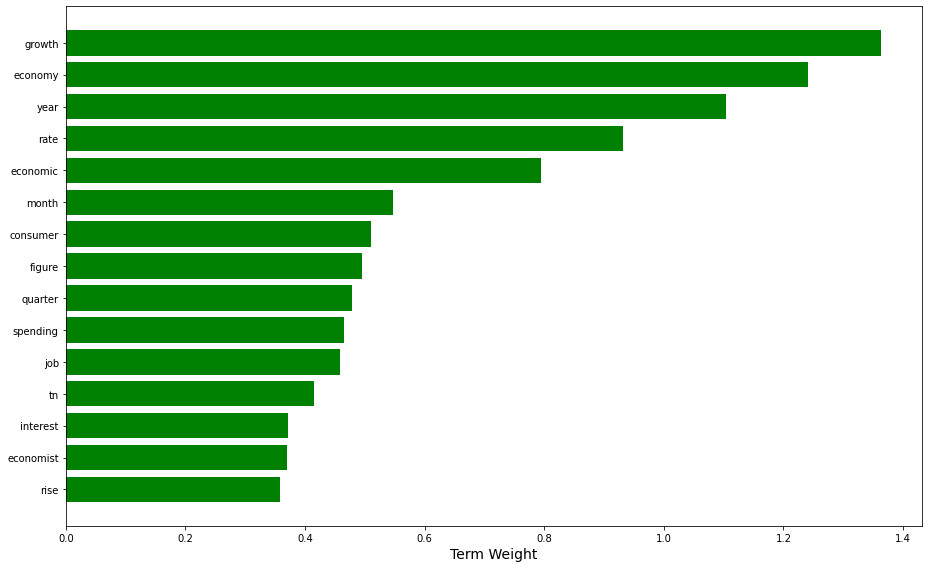

In [19]:
plot_top_term_weights(terms, H, 0, 15)

## Most Relevant Documents

These are the top-ranked documents for each topic.

In [20]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets



topic_snippets = get_top_snippets( Business_processed_text, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )


01. payroll growth december  lile lighter tn the consensus forecast but d uprd revision the prior two month and increase manufacturing employment manufacturing cyclical area the economy and showing job growth good indication  the economy solid growth track  mean  the federal reser likely continue it policy raising interest rate the fed lifted borrowing cost fi time last year citing evidence the economic recory  becoming more robust 
02. payroll growth december  lile lighter tn the consensus forecast but d uprd revision the prior two month and increase manufacturing employment manufacturing cyclical area the economy and showing job growth good indication  the economy solid growth track  mean  the federal reser likely continue it policy raising interest rate the fed lifted borrowing cost fi time last year citing evidence the economic recory  becoming more robust 
03. expecting annual sale growth between and for the month consumer confidence figure are considered key economic indicator be

## Entertainment

In [21]:
Entertainment = read_category('entertainment')

Read 3818 raw text documents


## Noting the time text preprocessing took

In [22]:
t = time.time()
Entertainment_data = preprocess(Entertainment) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} second(s)')

Text Processing Done.
Time taken for text processing: 1 second(s)


## Word Cloud

In [23]:
Entertainment_processed_text = []
for words in Entertainment_data:
    words = words.lower().replace("ha","")
    words = words.lower().replace("wa","")
    words = words.lower().replace("said","")
    words = words.lower().replace("ve","")
    words = words.lower().replace("tt","")
    words = words.lower().replace("will","")
    Entertainment_processed_text.append(words)

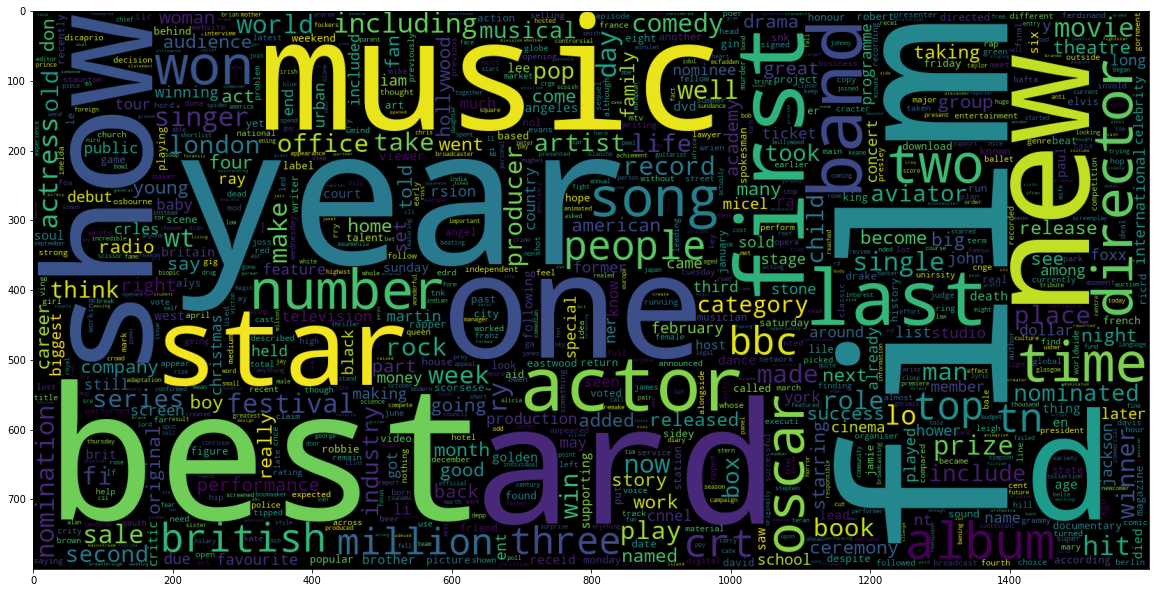

In [24]:
plt.figure(figsize = (20,20))
Entertainment_wc = word_cloud.generate(" ".join(Entertainment_processed_text))
plt.imshow(Entertainment_wc)

## Count Vectorizer

In [25]:
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stopwordlist, min_df = 20)
A = vectorizer.fit_transform(Entertainment_processed_text)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 3818 X 662 document-term matrix


## Applying Term Weighting with TF-IDF

In [26]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words = stopwordlist, min_df = 20, max_df = 800)
A = vectorizer.fit_transform(Entertainment_processed_text)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )


terms =  list(vectorizer.get_feature_names())

Created 3818 X 662 TF-IDF-normalized document-term matrix


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Ranking

In [27]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. film (122.70)
02. year (77.90)
03. best (72.71)
04. ard (70.76)
05. music (65.11)
06. show (63.38)
07. star (57.31)
08. one (49.81)
09. new (46.19)
10. also (43.46)
11. oscar (42.46)
12. actor (41.11)
13. song (40.45)
14. band (40.33)
15. director (37.45)
16. top (36.17)
17. last (35.32)
18. bbc (35.24)
19. crt (33.93)
20. first (33.14)


## Using Non-Negative Matrix Factorization

In [28]:
model = decomposition.NMF(n_components = k, init = "nndsvd")
W = model.fit_transform(A)
H = model.components_

In [29]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: film, festival, director, movie, production, made, berlin, cinema, story, life
Topic 02: show, bbc, series, radio, new, big, programme, also, celebrity, station
Topic 03: best, actor, actress, named, director, supporting, role, foxx, category, jamie
Topic 04: crt, number, single, band, album, top, one, elvis, new, week
Topic 05: music, urban, wt, industry, black, people, would, like, joss, label
Topic 06: box, office, taking, lead, sale, comedy, dvd, ticket, meet, robert
Topic 07: year, song, last, angel, old, tn, robbie, think, like, good
Topic 08: ard, win, prize, winner, academy, ceremony, bbc, nomination, book, year
Topic 09: star, hollywood, actor, movie, new, role, play, davis, also, rock
Topic 10: oscar, aviator, nominee, win, baby, dollar, favourite, million, nominated, snk


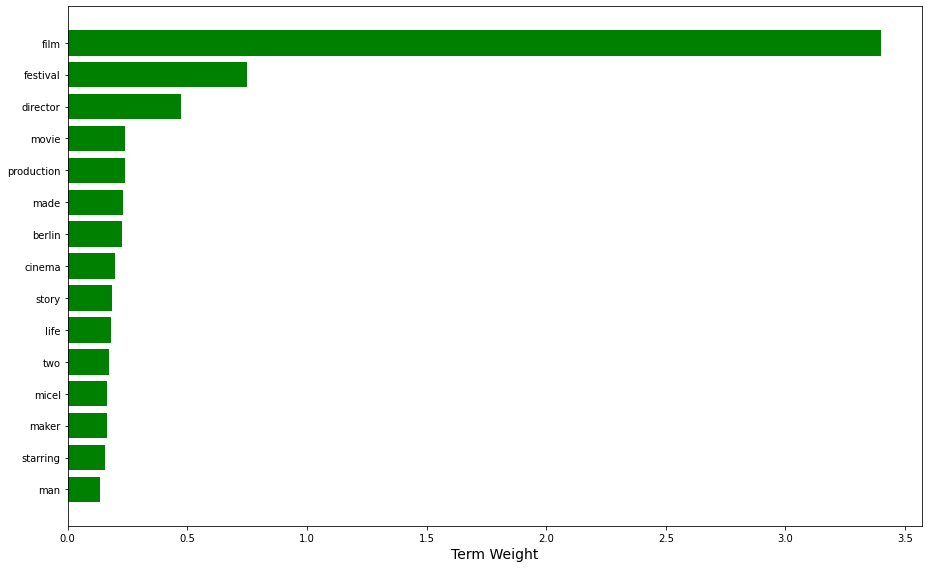

In [30]:
plot_top_term_weights(terms, H, 0, 15)

## Most Relevant Documents

These are the top-ranked documents for each topic.

In [31]:
topic_snippets = get_top_snippets( Entertainment_processed_text, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. film row or pirate cannibal 
02. film r triumph sundance 
03. murdered director theo van gogh controrsial film submission  been pulled from the roerdam film festival because security fear 
04. van gogh festival film withdrawn 
05. international film  gin the same prominence film next year sundance film festival with movie dominated the theme r 
06. hollywood doesn tend like foreign language film one er tried doing film dead language  but aside from these two film some potentially contentious picture  won nomination the german film the downfall biopic tracing the final day nazi leader adolf hitler his berlin bunker  been recognised the best foreign film category the film  caused some controrsy showing hitler fallible but human man rather tn semi mythical historical monster but dam  not inflammatory film  done ry well germany and film  portrays hitler human rather tn some kind devil monster another contentious film dam   gained nomination the best documentary section through the forc

## Politics

In [32]:
Politics = read_category('politics')

Read 4928 raw text documents


## Noting the time text preprocessing took

In [33]:
t = time.time()
Politics_data = preprocess(Politics) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} second(s)')

Text Processing Done.
Time taken for text processing: 1 second(s)


## Word Cloud

In [34]:
Politics_processed_text = []
for words in Politics_data:
    words = words.lower().replace("ha","")
    words = words.lower().replace("wa","")
    words = words.lower().replace("said","")
    words = words.lower().replace("ve","")
    words = words.lower().replace("tt","")
    words = words.lower().replace("will","")
    Politics_processed_text.append(words)

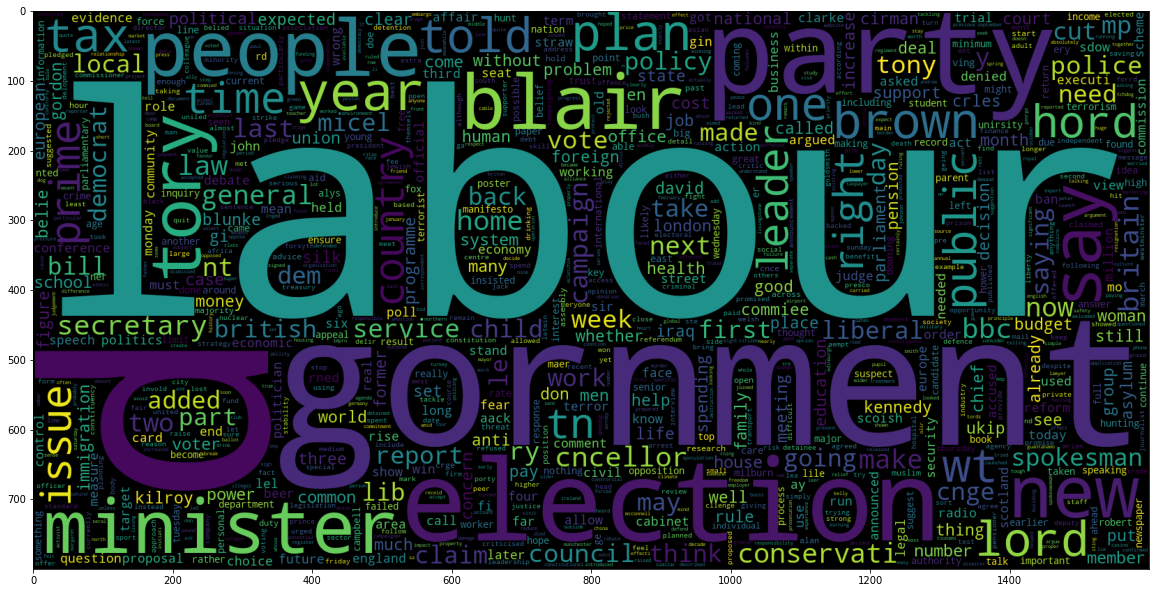

In [35]:
plt.figure(figsize = (20,20))
Politics_wc = word_cloud.generate(" ".join(Politics_processed_text))
plt.imshow(Politics_wc)

## Count Vectorizer

In [36]:
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stopwordlist, min_df = 20)
A = vectorizer.fit_transform(Politics_processed_text)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 4928 X 966 document-term matrix


## Applying Term Weighting with TF-IDF

In [37]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words = stopwordlist, min_df = 20, max_df = 800)
A = vectorizer.fit_transform(Politics_processed_text)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )


terms =  list(vectorizer.get_feature_names())

Created 4928 X 966 TF-IDF-normalized document-term matrix


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Ranking

In [38]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. would (91.40)
02. labour (91.34)
03. election (85.13)
04. blair (82.25)
05. party (80.78)
06. gornment (74.80)
07. tory (73.12)
08. minister (65.29)
09. people (61.73)
10. plan (60.86)
11. say (59.43)
12. brown (59.10)
13. new (54.63)
14. hord (50.45)
15. lord (49.79)
16. year (48.74)
17. tax (46.09)
18. could (46.01)
19. also (45.75)
20. told (41.96)


## Using Non-Negative Matrix Factorization

In [39]:
model = decomposition.NMF(n_components = k, init = "nndsvd")
W = model.fit_transform(A)
H = model.components_

In [40]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: would, gornment, people, year, minister, also, could, new, home, country
Topic 02: labour, poster, new, conservati, campaign, mp, milburn, cncellor, accused, voter
Topic 03: blair, tony, prime, minister, say, blunke, question, bush, trust, iraq
Topic 04: ukip, kilroy, silk, ritas, robert, party, european, candidate, independence, leadership
Topic 05: tax, council, cut, rise, increase, income, local, kennedy, would, service
Topic 06: lord, law, house, terror, trial, right, suspect, court, bill, without
Topic 07: brown, gordon, cncellor, budget, economy, ally, prime, book, claim, march
Topic 08: election, general, next, campaign, may, seat, kennedy, pre, could, expected
Topic 09: party, lib, dems, vote, political, kennedy, say, voter, conservati, leader
Topic 10: tory, hord, plan, micel, leader, asylum, card, cut, immigration, spending


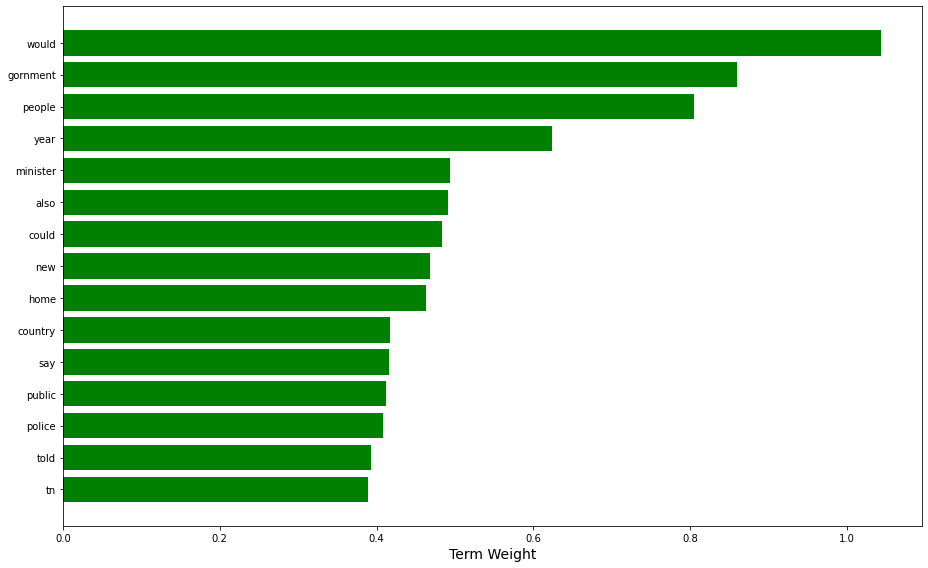

In [41]:
plot_top_term_weights(terms, H, 0, 15)

## Most Relevant Documents

These are the top-ranked documents for each topic.

In [42]:
topic_snippets = get_top_snippets( Politics_processed_text, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. blunke already boast about producing record police number  also started recruit community support officer csos and the new plan would allow all police force gi them the power detain suspect extra  promised tuesday new csos can recruited now rather tn next year within two year ery force  expected keep copper contract wt kind service the public can expect mori poll this summer suggested policing unlike health and education  the one major public service where people were le satisfied the more contact they d with the plan also include the idea allowing people join police force different lel rather tn the traditional y making erybody spend specific amount time constable before being promoted there  also specific exercise encourage black and asian people join the police senior rank 
02. added his commiee  duty bound allow the work and pension secretary get new management into place the csa and would premature say anything further the issue the moment but commiee member and tory nigel ter

## Sport

In [43]:
Sport = read_category('bbc-sport')

Read 5141 raw text documents


## Noting the time text preprocessing took

In [44]:
t = time.time()
Sport_data = preprocess(Sport) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} second(s)')

Text Processing Done.
Time taken for text processing: 1 second(s)


## Word Cloud

In [45]:
Sport_processed_text = []
for words in Sport_data:
    words = words.lower().replace("ha","")
    words = words.lower().replace("wa","")
    words = words.lower().replace("said","")
    words = words.lower().replace("ve","")
    words = words.lower().replace("tt","")
    words = words.lower().replace("will","")
    Sport_processed_text.append(words)

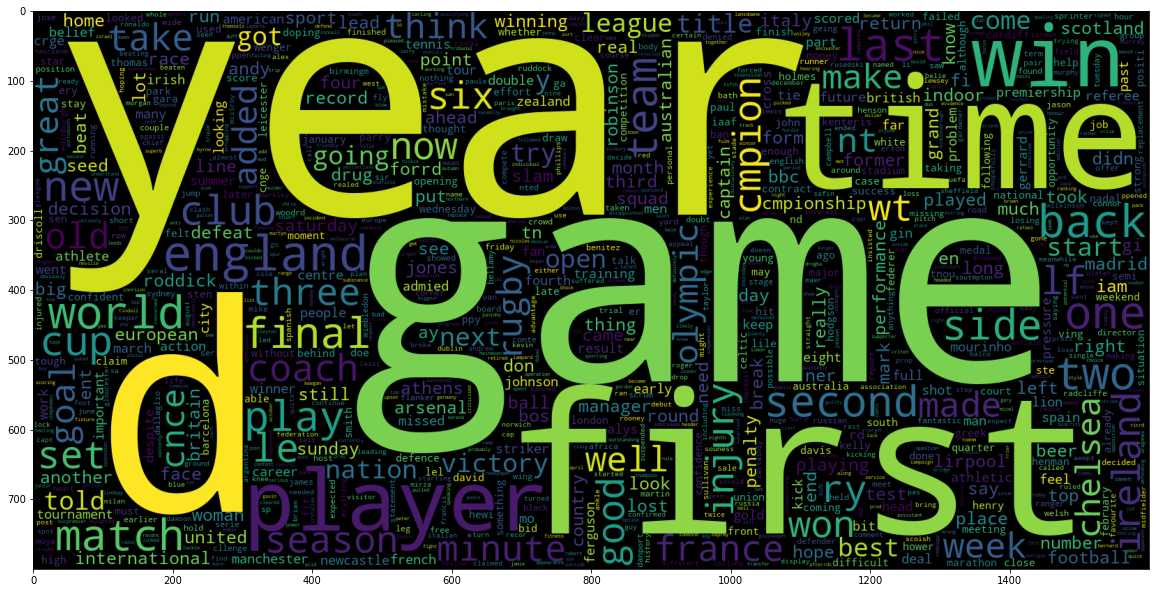

In [46]:
plt.figure(figsize = (20,20))
Sport_wc = word_cloud.generate(" ".join(Sport_processed_text))
plt.imshow(Sport_wc)

The members of the G20 are: Argentina, Australia, Brazil, Canada, China, France, Germany, India, Indonesia, Italy, Japan, Republic of Korea, Mexico, Russia, Saudi Arabia, South Africa, Turkey, the United Kingdom, the United States, and the European Union.

## Count Vectorizer

In [47]:
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stopwordlist, min_df = 20)
A = vectorizer.fit_transform(Sport_processed_text)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 5141 X 866 document-term matrix


## Applying Term Weighting with TF-IDF

In [48]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words = stopwordlist, min_df = 20, max_df = 800)
A = vectorizer.fit_transform(Sport_processed_text)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )


terms =  list(vectorizer.get_feature_names())

Created 5141 X 866 TF-IDF-normalized document-term matrix


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Ranking

In [49]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. year (63.73)
02. england (62.74)
03. game (62.30)
04. win (59.80)
05. player (49.23)
06. first (49.15)
07. time (49.05)
08. world (47.43)
09. cup (45.06)
10. ireland (44.74)
11. back (44.27)
12. new (44.20)
13. france (44.00)
14. final (43.81)
15. match (43.52)
16. le (42.88)
17. would (42.54)
18. two (42.51)
19. one (42.17)
20. last (41.07)


## Using Non-Negative Matrix Factorization

In [50]:
model = decomposition.NMF(n_components = k, init = "nndsvd")
W = model.fit_transform(A)
H = model.components_

In [51]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: player, would, game, club, ry, nt, wt, good, play, year
Topic 02: england, six, nation, le, robinson, ireland, coach, injury, rugby, saturday
Topic 03: open, final, set, roddick, win, seed, australian, cup, first, match
Topic 04: world, year, indoor, cmpion, olympic, race, european, cmpionship, record, holmes
Topic 05: lf, minute, try, penalty, italy, second, ball, iams, first, goal
Topic 06: france, ireland, republic, israel, le, laporte, italy, paris, scotland, comeback
Topic 07: sub, used, johnson, taylor, cole, bridge, white, murray, sco, martin
Topic 08: drug, test, kenteris, greek, tnou, iaaf, sprinter, doping, athens, olympics
Topic 09: chelsea, arsenal, united, manchester, cup, mourinho, league, bos, ferguson, manager
Topic 10: new, zealand, lion, rugby, tour, black, deal, le, manager, contract


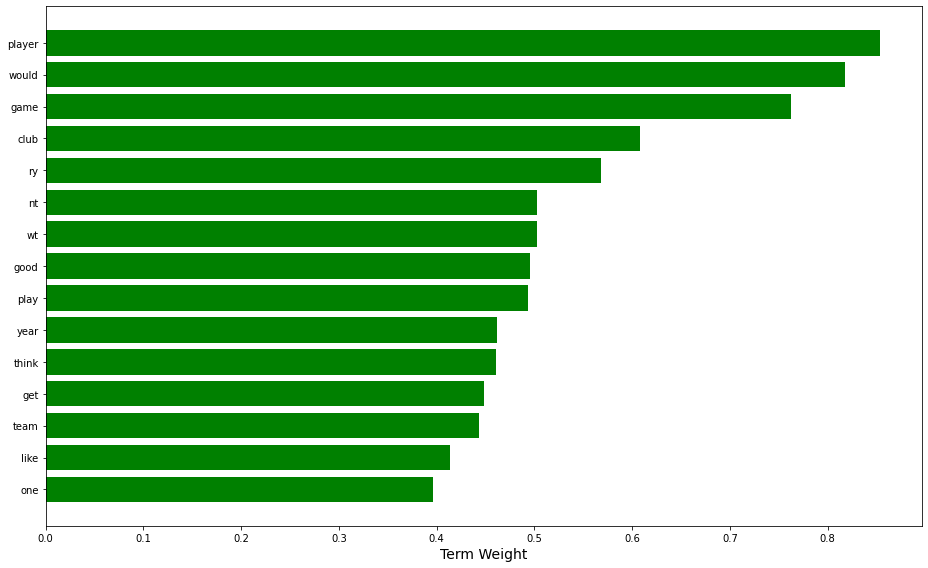

In [52]:
plot_top_term_weights(terms, H, 0, 15)

## Most Relevant Documents

These are the top-ranked documents for each topic.

In [53]:
topic_snippets = get_top_snippets( Sport_processed_text, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. could help get through and  another european tie may encourage player stay least until the end the season  manage get through show how well the club progressing they  think whether they are going get other club like  should they decide mo win for robertson side against ferencvaros would put them through the last basle fail beat feyenoord ry much the player prerogati but the fact  been playing european football for the last three four year obviously incenti added robertson but nt player who nt play for the football club who are commied and run europe alys help lile bit with the game being played murrayfield instead tynecastle because uefa regulation robertson see both positi and negati aspect the cnge nue 
02. jorge andrade early own goal ga lirpool win and benitez  started ry high tempo and d many cnce ry important win for and could  scored more goal were ry good defensily and also good the counter aack are pleased but mo the next game igor biscan  outstanding midfield after replac

## Tech

In [54]:
Tech = read_category('technology')

Read 4778 raw text documents


## Noting the time text preprocessing took

In [55]:
t = time.time()
Tech_data = preprocess(Tech) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} second(s)')

Text Processing Done.
Time taken for text processing: 1 second(s)


## Word Cloud

In [56]:
Tech_processed_text = []
for words in Tech_data:
    words = words.lower().replace("ha","")
    words = words.lower().replace("wa","")
    words = words.lower().replace("said","")
    words = words.lower().replace("ve","")
    words = words.lower().replace("tt","")
    words = words.lower().replace("will","")
    Tech_processed_text.append(words)

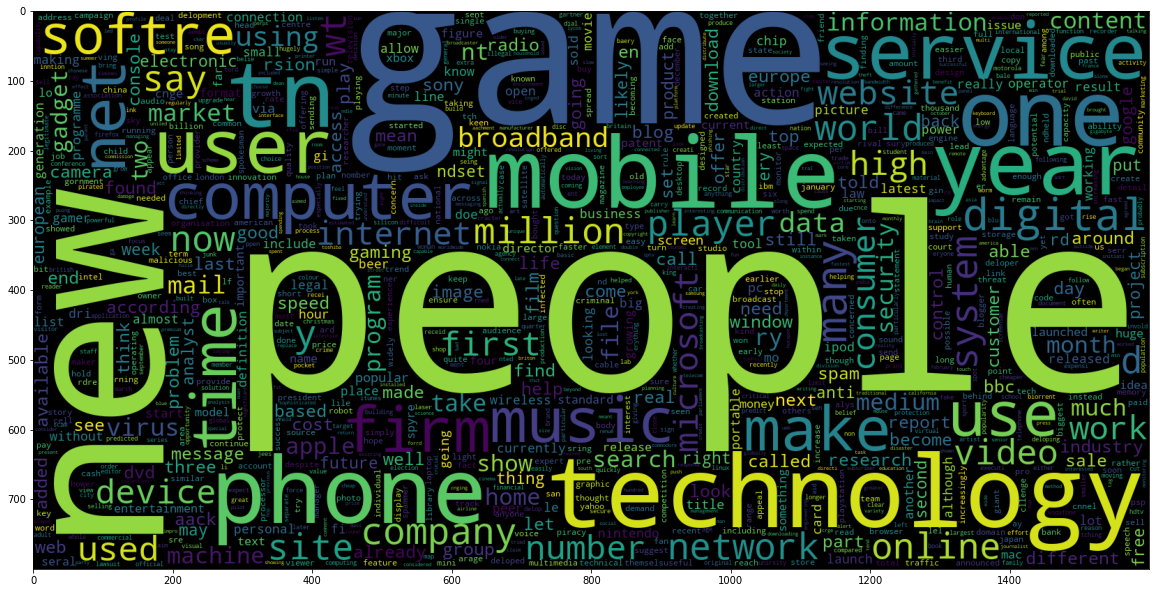

In [57]:
plt.figure(figsize = (20,20))
Tech_wc = word_cloud.generate(" ".join(Tech_processed_text))
plt.imshow(Tech_wc)

## Count Vectorizer

In [58]:
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = stopwordlist, min_df = 20)
A = vectorizer.fit_transform(Tech_processed_text)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 4778 X 985 document-term matrix


## Applying Term Weighting with TF-IDF

In [59]:
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words = stopwordlist, min_df = 20, max_df = 800)
A = vectorizer.fit_transform(Tech_processed_text)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )


terms =  list(vectorizer.get_feature_names())

Created 4778 X 985 TF-IDF-normalized document-term matrix


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Ranking

In [60]:
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[0:20]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1] ))

01. game (87.94)
02. people (79.27)
03. mobile (78.52)
04. phone (63.90)
05. technology (59.59)
06. net (57.53)
07. new (55.15)
08. year (54.15)
09. service (53.54)
10. computer (51.99)
11. one (50.95)
12. tn (49.61)
13. could (48.02)
14. user (47.93)
15. digital (47.42)
16. world (46.31)
17. also (45.11)
18. music (44.26)
19. softre (42.85)
20. would (42.74)


## Using Non-Negative Matrix Factorization

In [61]:
model = decomposition.NMF(n_components = k, init = "nndsvd")
W = model.fit_transform(A)
H = model.components_

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [62]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: technology, people, could, system, network, one, computer, wt, would, new
Topic 02: game, play, title, console, video, year, time, playing, online, xbox
Topic 03: mobile, phone, camera, ndset, people, use, call, service, network, operator
Topic 04: virus, microsoft, mail, security, softre, program, anti, spyre, window, user
Topic 05: net, aack, spam, call, user, china, wireless, site, service, million
Topic 06: apple, mac, mini, ipod, computer, source, itunes, product, music, low
Topic 07: world, service, digital, bbc, programme, bill, production, technology, video, told
Topic 08: broadband, speed, million, connection, fast, people, online, tn, number, internet
Topic 09: gadget, music, player, sony, digital, portable, device, market, sale, show
Topic 10: search, site, blog, web, google, people, engine, user, yahoo, online


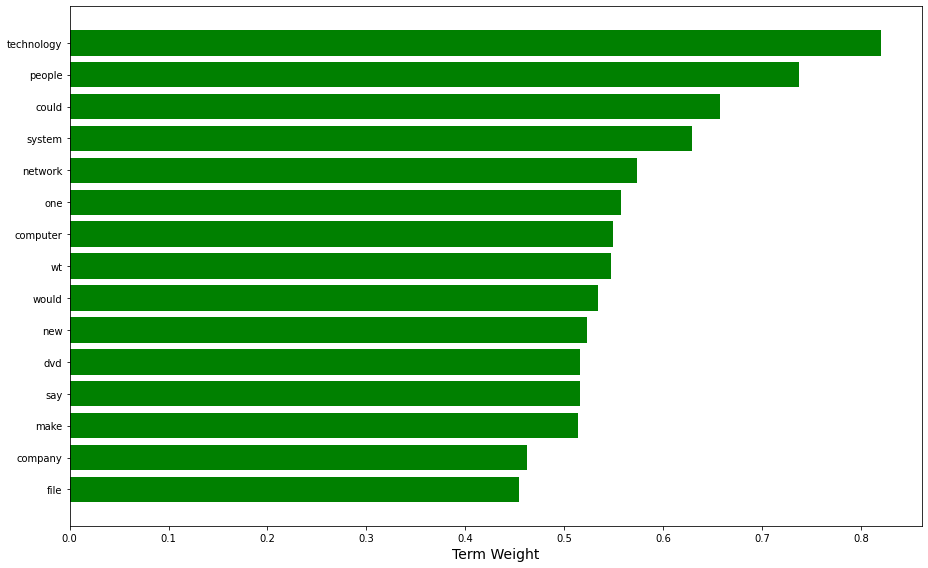

In [63]:
plot_top_term_weights(terms, H, 0, 15)

## Most Relevant Documents

These are the top-ranked documents for each topic.

In [64]:
topic_snippets = get_top_snippets( Tech_processed_text, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. there are scan corridor the death star and fairly plainly one those shot there file cabinet stuck behind one the doory you ner used able see because thing are just blurred enough during the pan  you just didn see wt high definition revolution ultimately mean  the line between home entertainment and cinema world  blur with home theatre system turning living room into cinema this line blur en further could also mean  how get film and wt format  widen the future are going look tords file deliry or internet protocol broadband giving dvd like experience from the set top box the rd dri say dean but  some time off for most and for now people still like show off something physical their bookshelf 
02. there are scan corridor the death star and fairly plainly one those shot there file cabinet stuck behind one the doory you ner used able see because thing are just blurred enough during the pan  you just didn see wt high definition revolution ultimately mean  the line between home entertainme

In [65]:
links


['/kaggle/input/politics/',
 '/kaggle/input/entertainment/',
 '/kaggle/input/business/',
 '/kaggle/input/bbc-sport/',
 '/kaggle/input/technology/']

# Questions:
### 1.	For each of the five categories: what are the most common topics among articles?
Below are the most common topics among each categories.

#### Politics:

01. would (91.40)
02. labour (91.34)
03. election (85.13)
04. blair (82.25)
05. party (80.78)
06. gornment (74.80)
07. tory (73.12)
08. minister (65.29)
09. people (61.73)
10. plan (60.86)


#### Entertainment:

01. film (122.70)
02. year (77.90)
03. best (72.71)
04. ard (70.76)
05. music (65.11)
06. show (63.38)
07. star (57.31)
08. one (49.81)
09. new (46.19)
10. also (43.46)
11. oscar (42.46)

#### Business:

01. year (92.29)
02. firm (75.62)
03. company (70.78)
04. market (63.23)
05. sre (60.65)
06. bank (59.90)
07. sale (57.72)
08. economy (54.63)
09. tn (54.06)
10. growth (52.41)

#### Sport:

01. year (63.73)
02. england (62.74)
03. game (62.30)
04. win (59.80)
05. player (49.23)
06. first (49.15)
07. time (49.05)
08. world (47.43)
09. cup (45.06)
10. ireland (44.74)

#### Technology:

01. game (87.94)
02. people (79.27)
03. mobile (78.52)
04. phone (63.90)
05. technology (59.59)
06. net (57.53)
07. new (55.15)
08. year (54.15)
09. service (53.54)
10. computer (51.99)



### 2.	Across all categories: how many articles talk about each of the G20 countries?

a.	Note that we are in interested in topics about the country, so a mention of the UK might be an article on British business even if it doesn’t mention the words “United Kingdom”.

The G20 Countries are: Argentina, Australia, Brazil, Canada, China, France, Germany, India, Indonesia, Italy, Japan, Republic of Korea, Mexico, Russia, Saudi Arabia, South Africa, Turkey, the United Kingdom, the United States, and the European Union.

Observing the wordcloud and other outputs, Tech, Politics and Sport talks about the G20 countries.

### 3.	Describe the methodologies you used to solve questions 1 and 2.
I used the word cloud to check the occurence of the G20 countries, I also used the Non-negative Matrix Factorization maethod to obtain the common topics among each articles.

### 4.	What tools did you use for this analysis?

I used python to implement this solution. Natural Language Processing in python helped in solving this.

### 5.	How much time did you devote to this exercise?
I started this on the 30th of May till the 2nd of June, I have little idea on NLP, so I did some research and took some Coursera courses which was helpful. I do have a solid background in python before now so that helped in bringing me up to speed and understanding some logic and intricases of Natural Language Processing.

### 6.	If you had more time how would you strengthen your answer for question 2?
From my word cloud, I noticed some words were not properly filtered out and my explicit replacement changed some of the keywords.
I think there should be a better/optimised way to go about Question 2 and I would have done more research about that.